# Introduction
For your third capstone, you’ll complete an unsupervised learning project. You can choose your own research question or choose from one below.

How do you achieve the following using clustering techniques?

    Your chief marketing officer wants to know how much website traffic is due to spam and bots versus actual customers. How can you group the traffic?

Next steps:

Go out and find a dataset of interest. It could be one that helps you work on one of our recommended research questions, or any other dataset that addresses an unsupervised learning question of your own.

Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.

Things to keep in mind: how do clustering and modeling compare? What are the advantages of each? Why would you want to use one over the other?

This will ultimately include the following deliverables:

    A Jupyter notebook that tells a compelling story about your data (to be submitted at the end of this checkpoint).
    A 15 to 30 minute presentation of your findings. You'll need to produce a deck and present it to the Thinkful community.
    Conduct the analysis in Jupyter. Provide a complete research report using the framework introduced in the previous module. The report should include compelling visualizations and actionable insights, telling the story to your intended audience. Walk through the analysis using clean, reproducible code. Include plenty of notes and comments to guide others through your thinking.

    Rather than create a deck in a presentation tool like PowerPoint or Google Slides, we will use Jupyter’s built-in slide deck capabilities. This cuts down on the time-consuming and error-prone process of copying-and-pasting into an external program. The presentation is also fully reproducible.

    On the day of your presentation, an evaluator from the Thinkful educator team will introduce you, and then you'll give your presentation. Afterward, the evaluator will ask you follow up questions and will grade your performance on your presentation. Members of the audience will also be encouraged to ask follow up questions.

Be prepared to talk about:

1. Your end-user and the value your project provides to them.
2. Quantifiable results based on the research you’ve conducted.
3. The visuals you chose and what they represent for your research.
4. Next steps you'd take to expand on your work.
5. A specified research question your model addresses.
6. How you chose your model specification and what alternatives you compared it to.
7. The practical uses of your model for an audience of interest.
8. Any weak points or shortcomings of your model.

# Cleaning and Importing Data
The dataset was obtained from Kaggle.com. It is 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12316 non-null float64
Administrative_Duration    12316 non-null float64
Informational              12316 non-null float64
Informational_Duration     12316 non-null float64
ProductRelated             12316 non-null float64
ProductRelated_Duration    12316 non-null float64
BounceRates                12316 non-null float64
ExitRates                  12316 non-null float64
PageValues                 12330 non-null float64
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null int64
Browser                    12330 non-null int64
Region                     12330 non-null int64
TrafficType                12330 non-null int64
VisitorType                12330 non-null object
Weekend                    12330 non-null bool
Revenue                    12330 non-null bool
dtypes:

In [4]:
df.isna().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

In [5]:
df = df.fillna(0)
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [6]:
# Convert boolean column to 0 for false, 1 for true
bools = df[df.columns[-2:]]

for x in bools:
    df[x] = df[x].astype(int)

In [7]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.814312,0.503406,34.467207,31.727818,1194.679026,0.022127,0.042954,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586,0.232603,0.154745
std,3.321784,176.780989,1.270093,140.750298,44.477938,1913.709257,0.048405,0.048521,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169,0.422509,0.361676
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.025000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000,0.000000
50%,1.000000,7.312500,0.000000,0.000000,18.000000,598.936905,0.003089,0.025044,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,0.000000,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016667,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000,1.000000,1.000000


In [8]:
# Create dataset with only float columns
num_values = df.select_dtypes(include='float64')

# Replace rows with duration less than 0 with median
for num in num_values:
    i = 0
    for i, x in enumerate(df[num]):
        if x < 0:
            df.loc[i, num] = np.median(df[num])
            i += 1

In [9]:
def num_outliers(data, threshold):
    """ Count of all outliers of data
    Parameters 
    data(DataFrame): values used for z-score calc
    threshold(int): number of std deviations
    
    Returns outlier count for each column"""
    
    print('Number of Outliers per Column')

    for num in num_values:
        z = np.abs(stats.zscore(df[num]))
        outliers = np.where(z>3)
        count = np.count_nonzero(outliers)
        print('{}: {}'.format(num, count))
        
    return

In [10]:
# Print count of values outside of 3 std deviations
threshold = 3

num_outliers(num_values, threshold)

Number of Outliers per Column
Administrative: 213
Administrative_Duration: 232
Informational: 260
Informational_Duration: 230
ProductRelated: 236
ProductRelated_Duration: 219
BounceRates: 704
ExitRates: 708
PageValues: 259
SpecialDay: 479


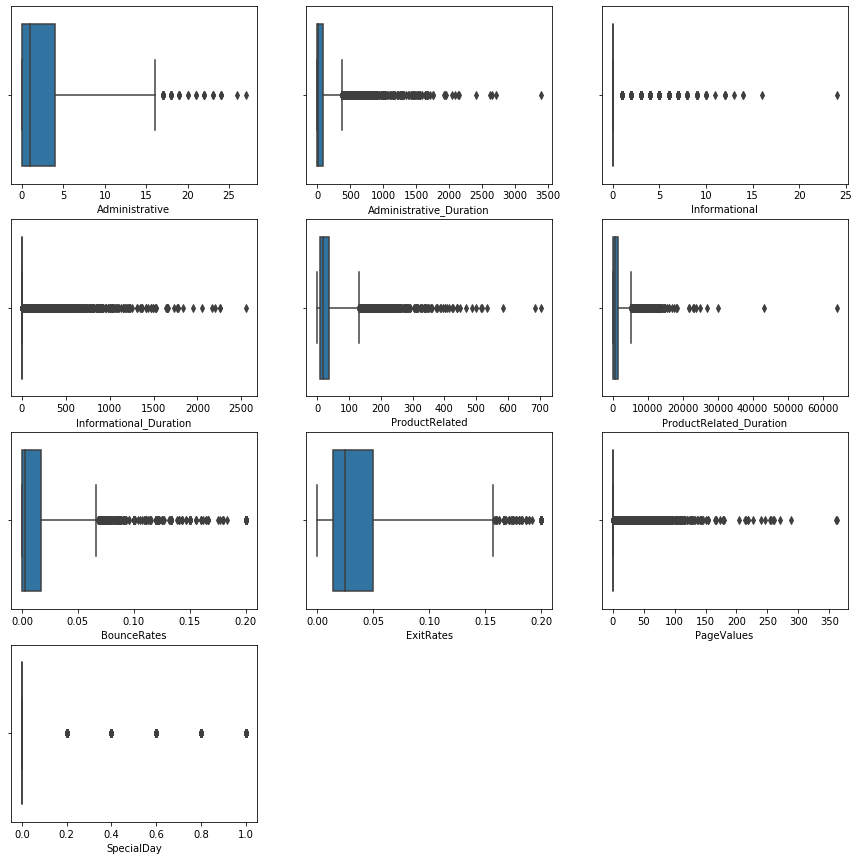

In [11]:
# Plot boxplots of num_values
plt.figure(figsize=(15, 15))
i = 0

for i, num in enumerate(num_values):
    i += 1
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[num], whis=3)
    
plt.show()

In [12]:
# Log transform the data
for x in num_values:
    df[x] = np.log1p(df[x])

# Print number of outliers
num_outliers(num_values, threshold)

Number of Outliers per Column
Administrative: 0
Administrative_Duration: 0
Informational: 260
Informational_Duration: 182
ProductRelated: 4
ProductRelated_Duration: 0
BounceRates: 708
ExitRates: 706
PageValues: 131
SpecialDay: 479


# Data Exploration


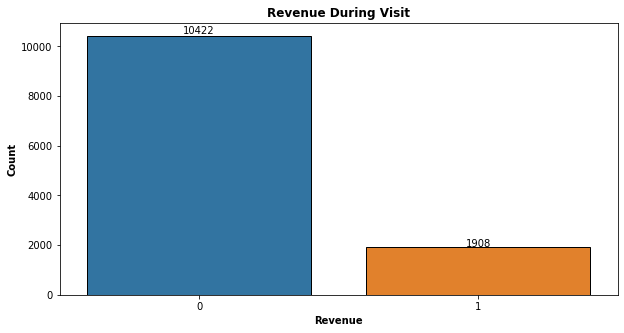

In [13]:
plt.figure(figsize=(10, 5))

graph = sns.countplot(x=df['Revenue'], edgecolor='black')

# Add countbar total for each bar
for i, p in enumerate(graph.patches):
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height*1.01,
        df['Revenue'].value_counts()[i], ha="center")

plt.title('Revenue During Visit', fontweight='bold')
plt.xlabel('Revenue', fontweight='bold')
plt.ylabel('Count', fontweight='bold')

plt.show()

In [14]:
sales = df['Revenue'].value_counts()
visits = sales.sum()
convert = round(sales[1]/visits, 4)

print('Sale during visit:\n', sales)

print('\nPercentage of visits that convert to sales: {}%'.format(convert*100))

Sale during visit:
 0    10422
1     1908
Name: Revenue, dtype: int64

Percentage of visits that convert to sales: 15.47%


## Clustering

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12330 non-null float64
Administrative_Duration    12330 non-null float64
Informational              12330 non-null float64
Informational_Duration     12330 non-null float64
ProductRelated             12330 non-null float64
ProductRelated_Duration    12330 non-null float64
BounceRates                12330 non-null float64
ExitRates                  12330 non-null float64
PageValues                 12330 non-null float64
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null int64
Browser                    12330 non-null int64
Region                     12330 non-null int64
TrafficType                12330 non-null int64
VisitorType                12330 non-null object
Weekend                    12330 non-null int32
Revenue                    12330 non-null int32
dtype

In [24]:
objects = df.select_dtypes(include='object')

for obj in objects:
    temp = {i: j for j, i in enumerate(set(df[obj]))} 
    res = [temp[i] for i in df[obj]] 
    df[obj] = list(res)

X = df.drop('Revenue', axis=1)
print(X.head())

X = normalize(X)

   Administrative  Administrative_Duration  Informational  \
0             0.0                  0.00000            0.0   
1             0.0                  0.00000            0.0   
2             0.0                  2.11776            0.0   
3             0.0                  0.00000            0.0   
4             0.0                  0.00000            0.0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0        0.693147                 0.000000   
1                     0.0        1.098612                 4.174387   
2                     0.0        0.693147                 6.396824   
3                     0.0        1.098612                 1.299283   
4                     0.0        2.397895                 6.443336   

   BounceRates  ExitRates  PageValues  SpecialDay  Month  OperatingSystems  \
0     0.182322   0.182322         0.0         0.0      2                 1   
1     0.000000   0.095310         0.0         0.0      2

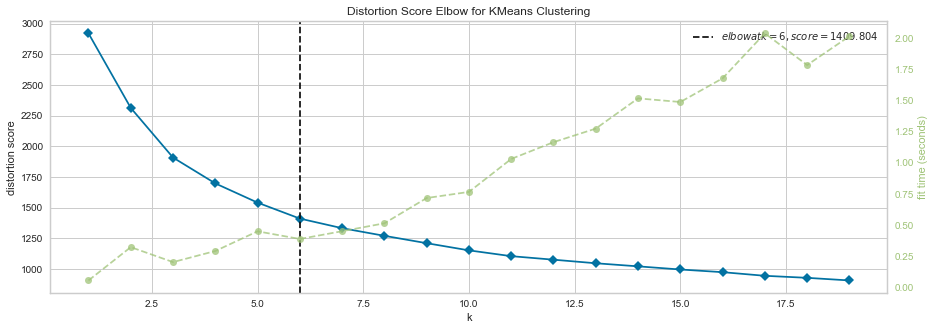

In [22]:
km = KMeans()

plt.figure(figsize=(15, 5))

# Find the optimal number of clusters for KMeans
vis = KElbowVisualizer(km, k=(1,20))
vis.fit(X)
vis.poof()
n = vis.elbow_value_

plt.show()

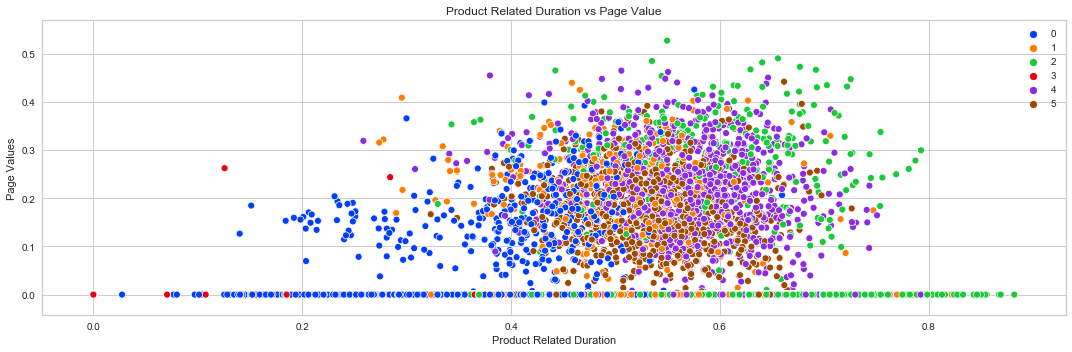

In [27]:
plt.figure(figsize=(15, 5))

model = KMeans(n_clusters=n).fit_predict(X)
pal = sns.color_palette('bright', n)
sns.scatterplot(x=X[:,5], y=X[:,8], hue=model, palette=pal)
plt.xlabel('Product Related Duration')
plt.ylabel('Page Values')
plt.title('Product Related Duration vs Page Value')

plt.tight_layout()
plt.show()

# Summary and Conclusion

# References
Data - https://www.kaggle.com/roshansharma/online-shoppers-intention